## PROJECT 35: Bitcoin price forecasting

> ### TASK: Stady Neural basis expansion analysis for interpretable time series forecasting


### Project goals and objectives

#### Project goal

- Studying **N-BEATS for forecasting time series**

#### Project objectives

1. Explore and prepare data 
2. Building N-BEATS model


### IMPORT LIBRARIES

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('whitegrid')

import re
import math as math

import tensorflow as tf


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import pandas.testing as tm
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat

import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Input,  MaxPool1D
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.layers import LSTM


import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### LOAD DATA

In [5]:
# Path to data
data_path ="/content/drive/MyDrive/Project_35_Bitcoin_price_forecasting/BTC_USD_2014-11-02_2021-11-15-CoinDesk.csv"

In [6]:
# Load the data
data_df = pd.read_csv(data_path, parse_dates=['Date'], index_col=['Date'])

# Check result 
data_df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-02,BTC,325.22633,338.01050,338.12950,319.36700
2014-11-03,BTC,331.60083,325.22633,333.75983,319.04350
2014-11-04,BTC,324.71833,331.60083,332.75133,323.06333
2014-11-05,BTC,332.45666,324.71833,335.81166,320.93333
2014-11-06,BTC,336.58500,332.45666,341.49000,328.56166


**For further research and model construction, we will take only the time series of the close price.**

In [7]:
# Take a columns
data_df =  data_df[['Closing Price (USD)']]

# Check result 
data_df.head()

,Closing Price (USD)
Date,
2014-11-02,325.22633
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500


### EXPLORATORY DATA ANALYSIS

In [8]:
# Check the missing values
print("Check the number of records")
print("Number of records: ", data_df.shape[0], "\n")

print("Null analysis")
empty_sample = data_df[data_df.isnull().any(axis=1)]
print("Number of records contain 1+ null: ", empty_sample.shape[0], "\n")

Check the number of records
Number of records:  2567 

Null analysis
Number of records contain 1+ null:  0 



In [9]:
data_df.shape

(2567, 1)

In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2567 entries, 2014-11-02 to 2021-11-15
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Closing Price (USD)  2567 non-null   float64
dtypes: float64(1)
memory usage: 40.1 KB


#### Distribution analysis

In [11]:
def distribution(data_for_eda):
    
    fig, ax = plt.subplots(1,3, figsize=(25, 5))
    fig.subplots_adjust(wspace=0.15)
    plt.suptitle("Distribution of observations", fontsize=18)
    
    sns.set_style("whitegrid")
    sns.histplot(data = data_for_eda, bins = 20, stat = 'density', kde = False, ax=ax[0])
    sns.boxenplot(data = data_for_eda, ax=ax[1])
    sns.ecdfplot(data = data_for_eda, ax=ax[2])
    
    fig, ax = plt.subplots(1,1, figsize=(25, 5))
    plt.plot(data_for_eda)
    plt.title("Montly Value", fontsize=18)
    
    print("Descriptive statistics:\n{}\n".format(data_for_eda.describe().round(2)) + '_' * 100+ '\n')
    print("Skew:\n{}\n".format(data_for_eda.skew().round(2))+ '_' * 100+ '\n')
    print("Kurtosis:\n{}\n".format(data_for_eda.kurt().round(2)) + '_' * 100+ '\n')

Descriptive statistics:
       Closing Price (USD)
count              2567.00
mean              10082.31
std               14748.69
min                 193.35
25%                 606.97
50%                6123.45
75%                9918.40
max               67633.65
____________________________________________________________________________________________________

Skew:
Closing Price (USD)    2.17
dtype: float64
____________________________________________________________________________________________________

Kurtosis:
Closing Price (USD)    3.79
dtype: float64
____________________________________________________________________________________________________



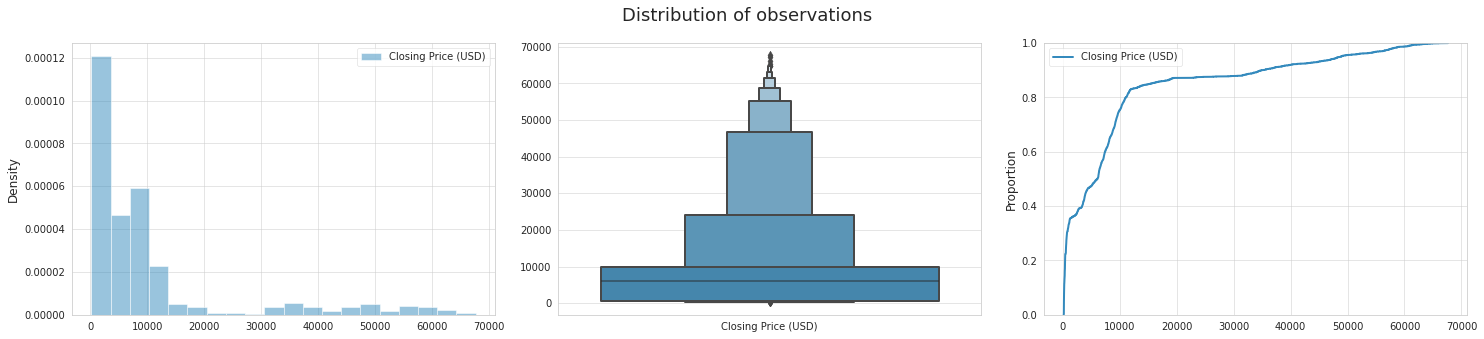

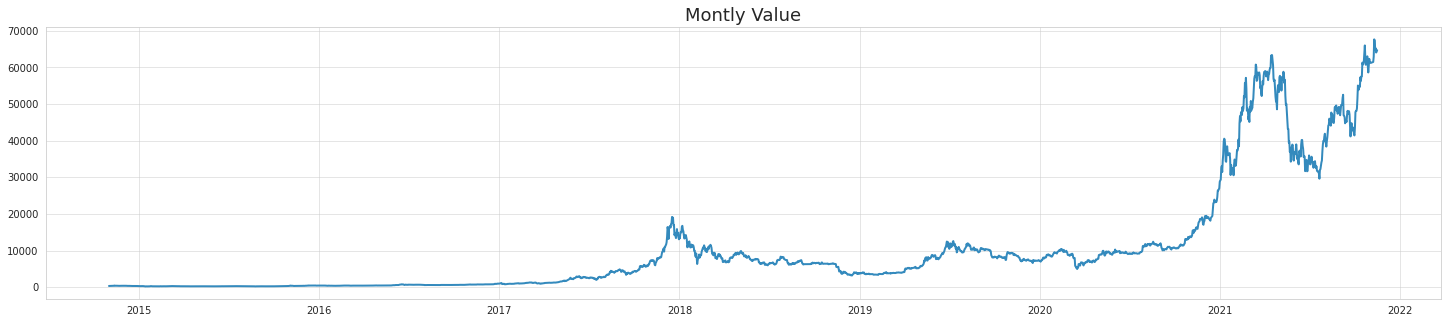

In [12]:
distribution(data_df)

#### Trend analysis

In [13]:
def trend_analysis(data_for_eda):
    # BUILDING MOVING AVERAGES
    
    # 7-day moving average
    data_7d_rol = data_for_eda.rolling(window = 7, center = True).mean()

    # 30-day moving average
    data_30d_rol = data_for_eda.rolling(window = 30, center = True).mean()

    # 365-day moving average
    data_365d_rol = data_for_eda.rolling(window = 365, center = True).mean()
    
    #PLOTTING MOVING AVERAGES
    
    fig, ax = plt.subplots(figsize = (20,5))

    # plotting daily data
    ax.plot(data_for_eda, marker='*', markersize=2, color='0.6',linestyle='None', label='Daily')

    # A fallback version of the presentation
    # ax.plot(novaya_entering_t2, linewidth=2, label='Daily', color='0.6', alpha = 0.5 )

    # plotting 7-day rolling data
    ax.plot(data_7d_rol, linewidth=2, label='7-d Rolling Mean')

    # plotting 30-day rolling data
    ax.plot(data_30d_rol, linewidth=2, label='30-d Rolling Mean')

    # plotting annual rolling data
    ax.plot(data_365d_rol, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean)')

        
    # Beautification of plot
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('People')
    ax.set_title('Trends in series', fontsize=18)

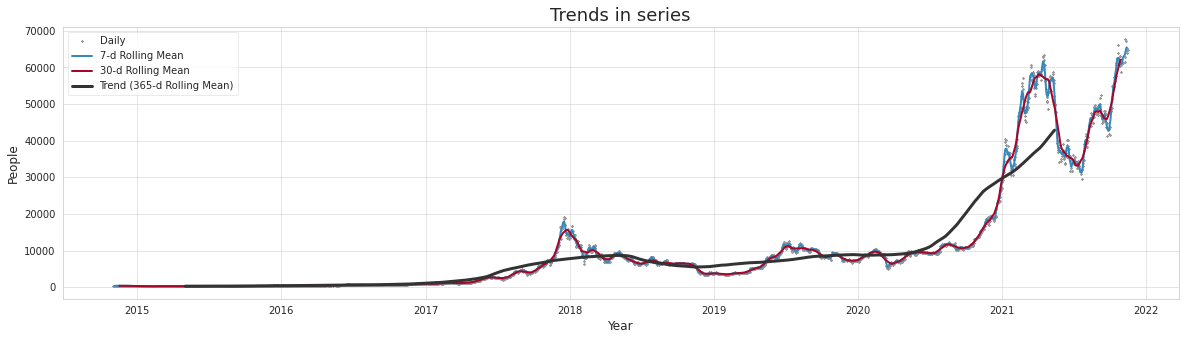

In [14]:
trend_analysis(data_df)

#### Autocorrelation analysis

In [15]:
def autocorr_analysis(data_for_eda):
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 3), dpi= 100)
    plt.suptitle("Autocorrelation analysis", fontsize=18)
    
    sm.graphics.tsa.plot_acf(data_for_eda.values.squeeze(), lags=50, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data_for_eda.values.squeeze(), lags=50, ax=ax[1])
    plt.show()

    fig, ax = plt.subplots(figsize=(19.7, 3), dpi= 100)
    pd.plotting.autocorrelation_plot(data_for_eda, ax=ax)
    plt.show()

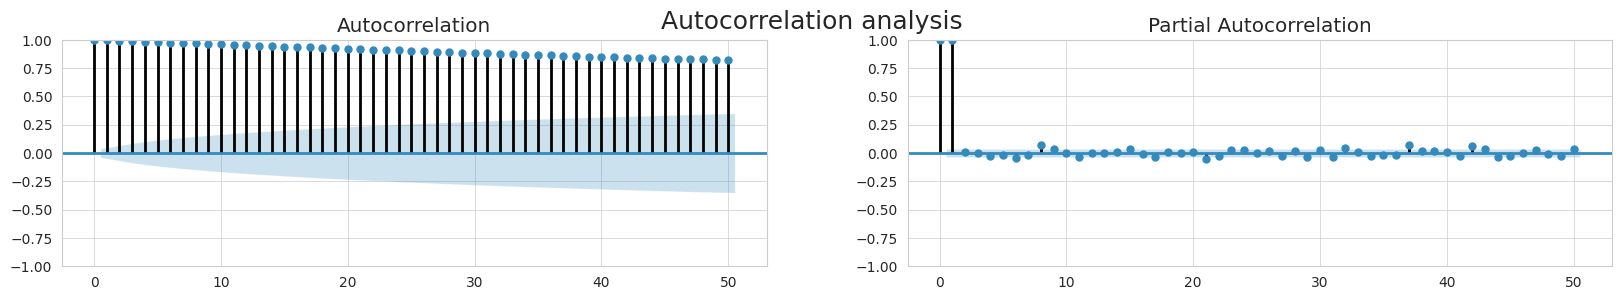

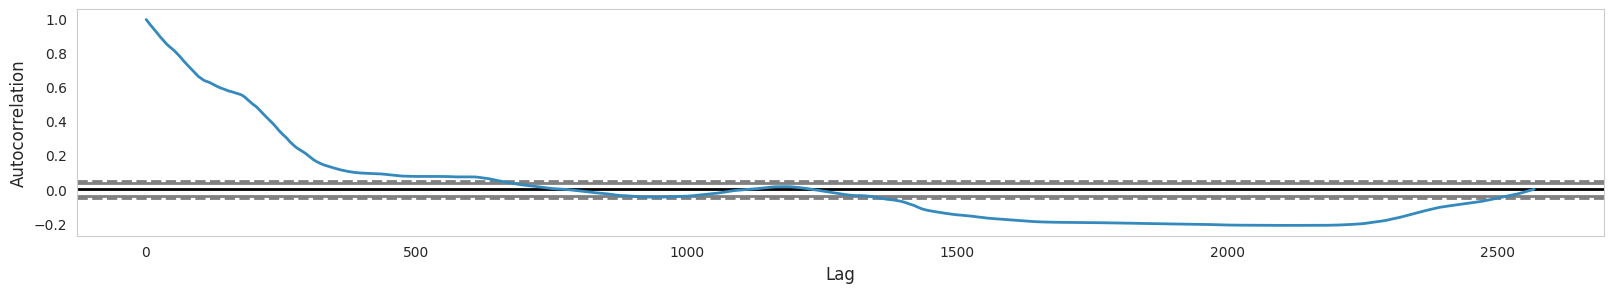

In [16]:
autocorr_analysis(data_df)

#### Analysis of seasonality

In [17]:
def seasonality_analysis(data_for_eda, period=365):
    seasonality = sm.tsa.seasonal_decompose(data_for_eda, model='additive', period=period).seasonal
    fig, ax = plt.subplots(figsize = (20,5))
    ax.plot(seasonality)

In [18]:
def decomposition(data_for_eda, period=365):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,5
        
    decomposition = sm.tsa.seasonal_decompose(data_for_eda, model='additive', period=period)
    
    decomposition.plot()
    plt.suptitle("Decomposition", fontsize=18)

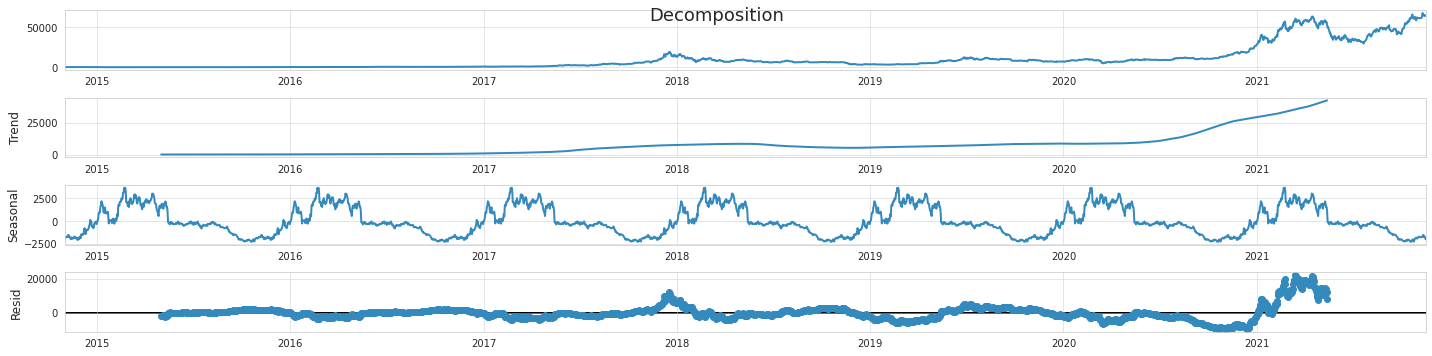

In [19]:
decomposition(data_df)

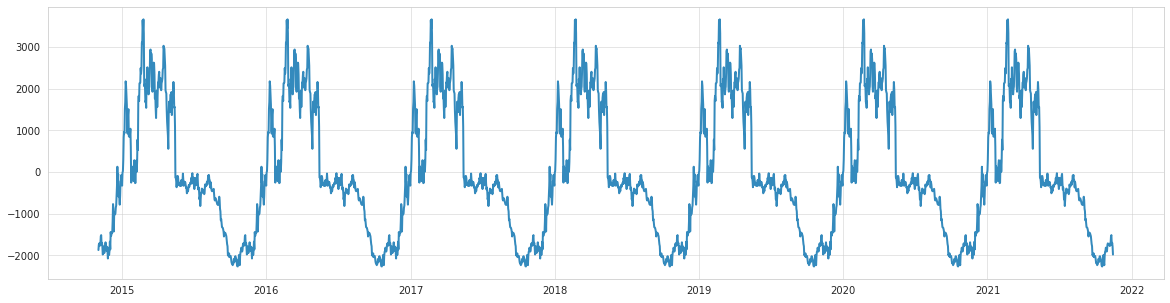

In [20]:
seasonality_analysis(data_df, period=365)

#### Analysis of stationarity

In [21]:
def stationarity_analysis(data_for_eda):
    test = sm.tsa.adfuller(data_for_eda)
    print ('adf:', test[0])
    print ('p-value:', test[1])
    print ('Critical values:', test[4])
    if test[0]> test[4]['5%']: 
        print ('\n There are single roots, the row is not stationary')
    else:
        print ('\n There are no single roots, the row is STATIONARY')

In [22]:
stationarity_analysis(data_df)

adf: 0.7913949793925601
p-value: 0.9914959894470073
Critical values: {'1%': -3.4329291671397715, '5%': -2.8626794698418867, '10%': -2.567376582654448}

 There are single roots, the row is not stationary


### DATA PREPARATION

Transform the data into a time series problem

In [23]:
def series_to_supervised(data, n_in=7, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [24]:
values = data_df.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

data_df_norm = series_to_supervised(scaled, n_in=14, n_out=7, dropnan=True)
data_df_norm.head()

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
14,0.001955,0.002050,0.001948,0.002063,0.002124,0.002275,0.002246,0.002220,0.002449,0.002591,0.002723,0.003689,0.002901,0.002989,0.002724,0.003071,0.002841,0.002706,0.002711,0.002302,0.002359
15,0.002050,0.001948,0.002063,0.002124,0.002275,0.002246,0.002220,0.002449,0.002591,0.002723,0.003689,0.002901,0.002989,0.002724,0.003071,0.002841,0.002706,0.002711,0.002302,0.002359,0.002424
16,0.001948,0.002063,0.002124,0.002275,0.002246,0.002220,0.002449,0.002591,0.002723,0.003689,0.002901,0.002989,0.002724,0.003071,0.002841,0.002706,0.002711,0.002302,0.002359,0.002424,0.002587
17,0.002063,0.002124,0.002275,0.002246,0.002220,0.002449,0.002591,0.002723,0.003689,0.002901,0.002989,0.002724,0.003071,0.002841,0.002706,0.002711,0.002302,0.002359,0.002424,0.002587,0.002786
18,0.002124,0.002275,0.002246,0.002220,0.002449,0.002591,0.002723,0.003689,0.002901,0.002989,0.002724,0.003071,0.002841,0.002706,0.002711,0.002302,0.002359,0.002424,0.002587,0.002786,0.002701


In [25]:
values = data_df_norm.values

n_train_time = int(len(data_df)*0.8)

train = values[:n_train_time, :]
test = values[n_train_time:, :]

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]


X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2053, 1, 20), (494, 1, 20), (2053,), (494,))

In [26]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(1024, return_sequences=True)(inputs)
x = Dropout(0.5)(x)

x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.5)(x)

x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.5)(x)

x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.5)(x)

x = LSTM(128, return_sequences=True)(x)
x = Dropout(0.5)(x)

x = LSTM(64)(x)
x = Dropout(0.5)(x)

outputs = Dense(1)(x)

model_LSTM = Model(inputs, outputs, name="LSTM_model")

In [27]:
# Compile model
model_LSTM.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mae"])

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 20)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 1024)           4280320   
                                                                 
 dropout (Dropout)           (None, 1, 1024)           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 512)            3147776   
                                                                 
 dropout_1 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 512)            2099200   
                                                                 
 dropout_2 (Dropout)         (None, 1, 512)            0

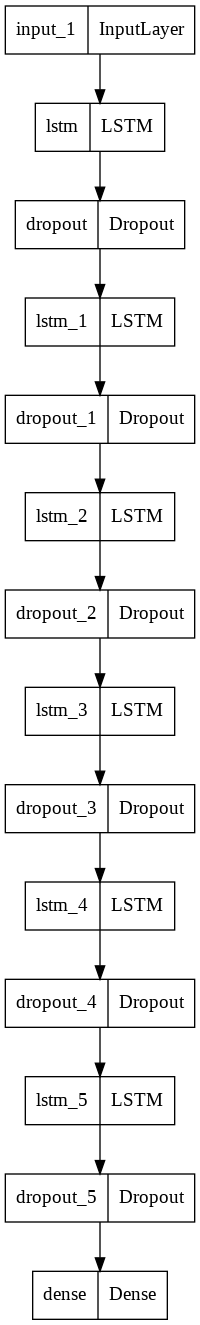

In [28]:
model_LSTM.summary()
tf.keras.utils.plot_model(model_LSTM, to_file='LSTM_model.png')

In [29]:
# Train model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=200,
                                                     restore_best_weights=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_LSTM.h5",
                                                   save_best_only=True)

reduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)

model_LSTM_history = model_LSTM.fit(X_train,
                                  y_train,
                                  batch_size=64,
                                  validation_split=0.15,
                                  epochs=5000,
                                  callbacks=[early_stopping_cb,
                                            checkpoint_cb, 
                                            reduceLROnPlateau])

Epoch 1/5000
28/28 [==============================] - 18s 128ms/step - loss: 0.0458 - mae: 0.0458 - val_loss: 0.1010 - val_mae: 0.1010 - lr: 0.0010
Epoch 2/5000
28/28 [==============================] - 1s 28ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0094 - val_mae: 0.0094 - lr: 0.0010
Epoch 3/5000
28/28 [==============================] - 1s 18ms/step - loss: 0.0117 - mae: 0.0117 - val_loss: 0.0112 - val_mae: 0.0112 - lr: 0.0010
Epoch 4/5000
28/28 [==============================] - 0s 17ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0105 - val_mae: 0.0105 - lr: 0.0010
Epoch 5/5000
28/28 [==============================] - 1s 29ms/step - loss: 0.0100 - mae: 0.0100 - val_loss: 0.0072 - val_mae: 0.0072 - lr: 0.0010
Epoch 6/5000
28/28 [==============================] - 0s 16ms/step - loss: 0.0098 - mae: 0.0098 - val_loss: 0.0076 - val_mae: 0.0076 - lr: 0.0010
Epoch 7/5000
28/28 [==============================] - 2s 62ms/step - loss: 0.0100 - mae: 0.0100 - val_loss: 0.0065 - val_m

### EVALUATION RESULT

In [30]:

# EVALUATION AND VISUALIZATION OF MODEL PARAMETERS
def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="Training loss")
    axL.plot(history.history['val_loss'], label="Validation loss")
    axL.set_title('Training and Validation loss')
    axL.set_xlabel('Epochs')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['mae'], label="Training mae")
    axR.plot(history.history['val_mae'], label="Validation mae")
    axR.set_title('Training and Validation mae')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('MAE')
    axR.legend(loc='upper right')

    plt.show()
    
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("People")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)


def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season


def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

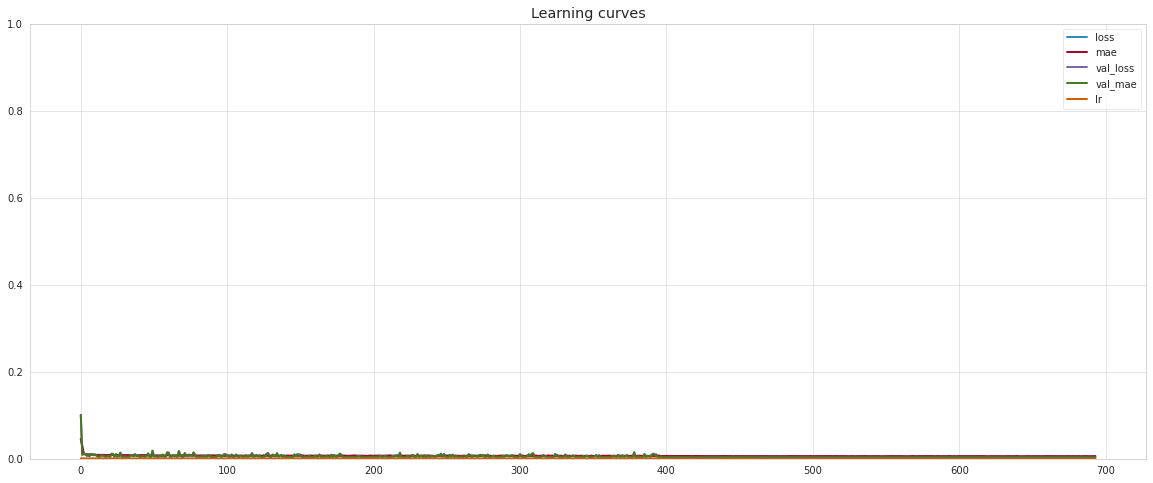

In [31]:
# Learning curves
learning_curves(model_LSTM_history)

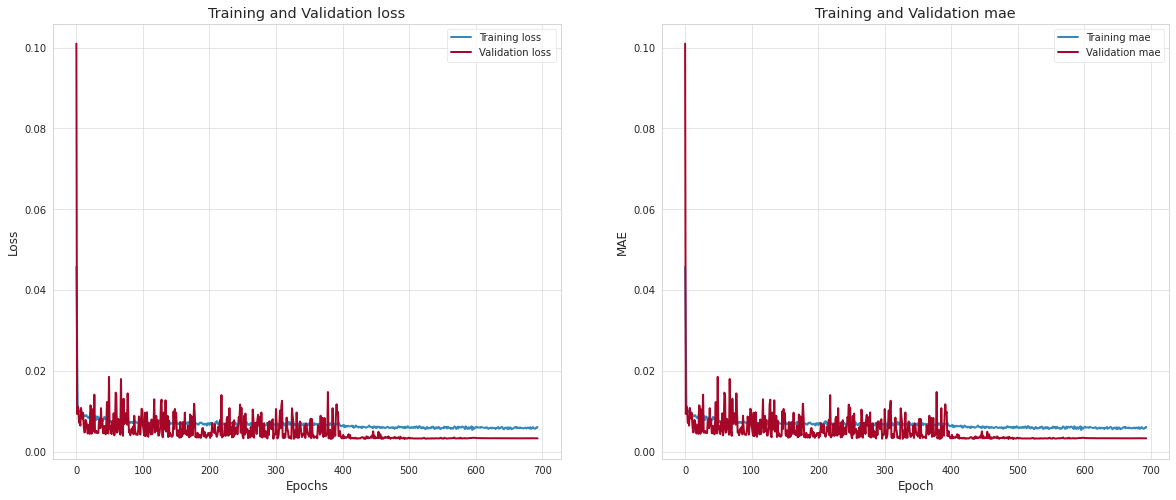

In [32]:
# Evaluation model
evaluation_model(model_LSTM_history)

In [33]:
# Evaluate model on test data
model_LSTM.evaluate(X_test, y_test)

16/16 [==============================] - 0s 7ms/step - loss: 0.2868 - mae: 0.2868


[0.28684329986572266, 0.28684329986572266]

In [34]:
# Load in saved best performing model_1 and evaluate on test data
model_LSTM = tf.keras.models.load_model("model_LSTM.h5")
model_LSTM.evaluate(X_test, y_test)

16/16 [==============================] - 3s 7ms/step - loss: 0.2868 - mae: 0.2868


[0.28684329986572266, 0.28684329986572266]

In [35]:
# Make predictions
model_LSTM_preds = make_preds(model_LSTM, X_test)
model_LSTM_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.13245751, 0.13182569, 0.13379678, 0.13428658, 0.13685392,
       0.13574082, 0.13520545, 0.13444029, 0.13490438, 0.13469355],
      dtype=float32)>

In [36]:
# Evaluate predictions
model_LSTM_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                   y_pred=model_LSTM_preds)
model_LSTM_results

{'mae': 0.2868433,
 'mape': 41.98016,
 'mase': 19.562899,
 'mse': 0.13803615,
 'rmse': 0.37153217}

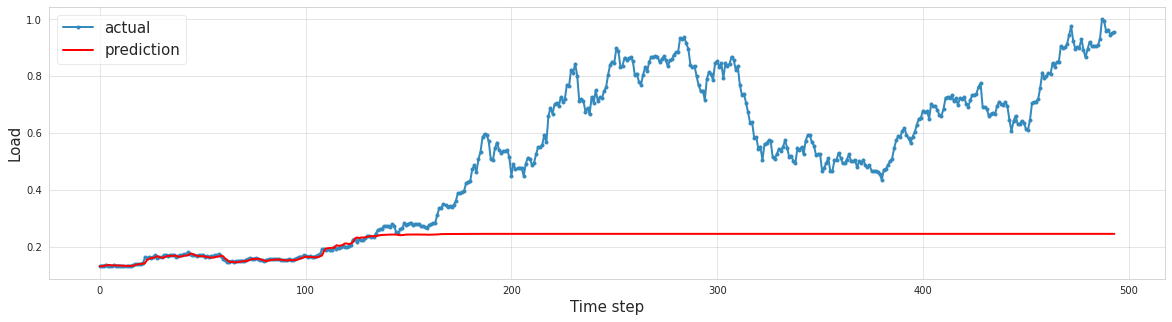

In [37]:
aa=[x for x in range(494)]
plt.plot(aa, y_test[:494], marker='.', label="actual")
plt.plot(aa, model_LSTM_preds[:494], 'r', label="prediction")
plt.ylabel('Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()